# AM 205 - Midterm

## By Jonathan Guillotte-Blouin

In [3]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

### Question 1: A stencil based on least squares

#### a) Calculate the coefficients $a_{-1}$, $a_0$, $a_1$, $a_2$, and $a_3$ to make a fourth-order accurate finite-difference formula.

To do this, we will use the Lagrange interpolant approach.

$$ \mathcal{L_{-1}}(z) = \frac{z(z-h)(z-2h)(z-3h)}{(-h)(-2h)(-3h)(-4h)} = \frac{z^4 - 6hz^3 + 11h^2z^2 - 6h^3z}{24h^4}$$

$$ \mathcal{L_{0}}(z) = \frac{(z+h)(z-h)(z-2h)(z-3h)}{h(-h)(-2h)(-3h)} = -\frac{z^4 - 5hz^3 + 5h^2z^2 + 5h^3z - 6h^4}{6h^4}$$

$$ \mathcal{L_{1}}(z) = \frac{(z+h)z(z-2h)(z-3h)}{(2h)h(-h)(-2h)} = \frac{z^4 - 4hz^3 + h^2z^2 + 6h^3z}{4h^4}$$

$$ \mathcal{L_{2}}(z) = \frac{(z+h)z(z-h)(z-3h)}{(3h)(2h)h(-h)} = -\frac{z^4 - 3hz^3 - h^2z^2 + 3h^3z}{6h^4}$$

$$ \mathcal{L_{3}}(z) = \frac{(z+h)z(z-h)(z-2h)}{(4h)(3h)(2h)h} = \frac{z^4 - 2hz^3 - h^2z^2 + 2h^3z}{24h^4}$$

$$ l'(z) = \mathcal{L'_{-1}}(z) \, f_{k-1} + \mathcal{L'_{0}}(z) \, f_k + \mathcal{L'_{1}}(z) \, f_{k+1} + \mathcal{L'_{2}}(z) \, f_{k+2} + \mathcal{L'_{3}}(z) \, f_{k+3} $$

$$ f'_{diff1}(x_k) = l'(0) = \frac{\frac{-1}{4} \, f_{k-1} + \frac{-5}{6} \, f_k  + \frac{3}{2} \, f_{k+1} + \frac{-1}{2} \, f_{k+2} + \frac{1}{12} \, f_{k+3}}{h} $$

#### b) Find the least squares best-fit quadratic through the same points.

In [62]:
def f_prime_diff2(k, xks, yks, N):
    xs = [xks[k-1], xks[k], xks[(k+1) % N], xks[(k+2) % N], xks[(k+3) % N]]
    b = [yks[k-1], yks[k], yks[(k+1) % N], yks[(k+2) % N], yks[(k+3) % N]]
    A = np.fliplr(np.vander(xs, 3))
    _, beta, gamma = np.linalg.lstsq(A, b, rcond=None)[0]
    
    return beta + 2 * gamma * xks[k]

0.3491110975900282

#### c) Which method gives a more accurate result for $f(x_k) = \cos(e^{3\cos(x)})$?

$$f'(x_k) = 3\sin(x_k)e^{3\cos(x_k)} \sin\left(e^{3\cos(x_k)}\right)$$

In [66]:
N = 1024
h = 2*np.pi/N
xks = [k*h for k in range(N)]
f_xk = lambda xk: np.cos(np.e**(3*np.cos(xk)))
f_prime_xk = lambda xk: 3 * np.sin(xk) * (np.e**(3*np.cos(xk))) * np.sin(np.e**(3*np.cos(xk)))
fk = [f_xk(xk) for xk in xks]
gk = [fk[i] + 1e-4 * np.random.normal(0, 1) for i in range(N)]

def f_prime_diff1(k, h, fk):
    numerator = (-1/4 * fk[k-1]) + (-5/6 * fk[k]) + (3/2 * fk[(k+1) % N]) + (-1/2 * fk[(k+2) % N]) + (1/12 * fk[(k+3) %N])
    return numerator / h

    

E1, E12, E2, E22 = 0, 0, 0, 0
for k in range(N):
    xk = k*h
    f_prime_result = f_prime_xk(xk)
    
    E1 += (f_prime_result - f_prime_diff1(k, h, fk))**2
    E12 += (f_prime_result - f_prime_diff1(k, h, gk))**2
    
    E2 += (f_prime_result - f_prime_diff2(k, xks, fk, N))**2
    E22 += (f_prime_result - f_prime_diff2(k, xks, gk, N))**2
E1 = np.sqrt(E1/N)
E12 = np.sqrt(E12/N)
E2 = np.sqrt(E2/N)
E22 = np.sqrt(E22/N)

print("E1:", E1)
print("E2:", E2)

E1: 6.646095327302529e-05
E2: 0.018548785431120516


From these results, it looks like the first method (quartic) is more accurate.

#### d) Calculate the new accuracies $E_1$ and $E_2$ using noisy value points $g_k = f_k + 10^{-4}z_k$.

In [67]:
print("E1 (with gk rather than fk):", E12)
print("E2 (with gk rather than fk):", E22)

E1 (with gk rather than fk): 0.03186233642293499
E2 (with gk rather than fk): 0.021227370696174367


From these results using noisy data, it looks like the second method (least squares quadratic) is more accurate.

I think the results from *c)* and *d)* make sense: least squares is an approximation, and so it is understandable that it is less precise than the exact quartic method. However, the exact quartic method does not handle well noisy data (it expects the real data to compute), while least squares is itself an approximation, and so it should be less affected by erronoeus data points.

### Question 2: A spline for exponential growth

#### a) Write a program that calculates the spline coefficients.

In [146]:
def get_spline_coeff(N, v=True):
    h = 1/N
    fx = lambda x: 10**x
    f_primex = lambda x: np.log(10) * 10**x
    A = np.zeros((3*N, 3*N))
    b = np.zeros(3*N)
    
    xs = np.linspace(0, 1, N+1)
    f = [fx(x) for x in xs]
    ctr = 0 # add new constraint to new row
    # loop through first 2N constraints (match endpoints)
    for i in range(N):
        xk = xs[i]
        xk_p1 = xs[i+1]
        A[ctr,i*3:i*3+3] = [xk**2, xk, 1]
        b[ctr] = f[i]
        ctr += 1
        A[ctr,i*3:i*3+3] = [xk_p1**2, xk_p1, 1]
        b[ctr] = f[i+1]
        ctr += 1
    
    # loop through next N-1 constraints (interior boundary for the derivative)
    for i in range(1, N):
        xk = xs[i]
        A[ctr, (i-1)*3:i*3] = [2*xk, 1, 0]
        A[ctr, i*3:(i+1)*3] = [-2*xk, -1, 0]
        ctr += 1
    
    # last constraint (10s'0(0) - s'n-1(1) = 0)
    A[ctr, 0:3] = [0, 10, 0]
    A[ctr, -3:] = [-2, 1, 0]
    
    x = np.linalg.solve(A, b)
    
    # print info about the quadratic splines
    if v:
        for k in range(N):
            ak, bk, ck = x[k*3:(k+1)*3]
            print("s{}(x) = {}x^2 + {}x + {}".format(k, ak, bk, ck))
        
    return x

#### b) For $N=3$, plot the spline s and the function f on the same axes.

s0(x) = -0.009066512196181042x^2 + 3.466326240827711x + 1.0
s1(x) = 12.003541594137275x^2 + -4.542079163394592x + 2.3347342340370503
s2(x) = 13.837771611119667x^2 + -6.987719186037779x + 3.149947574918113


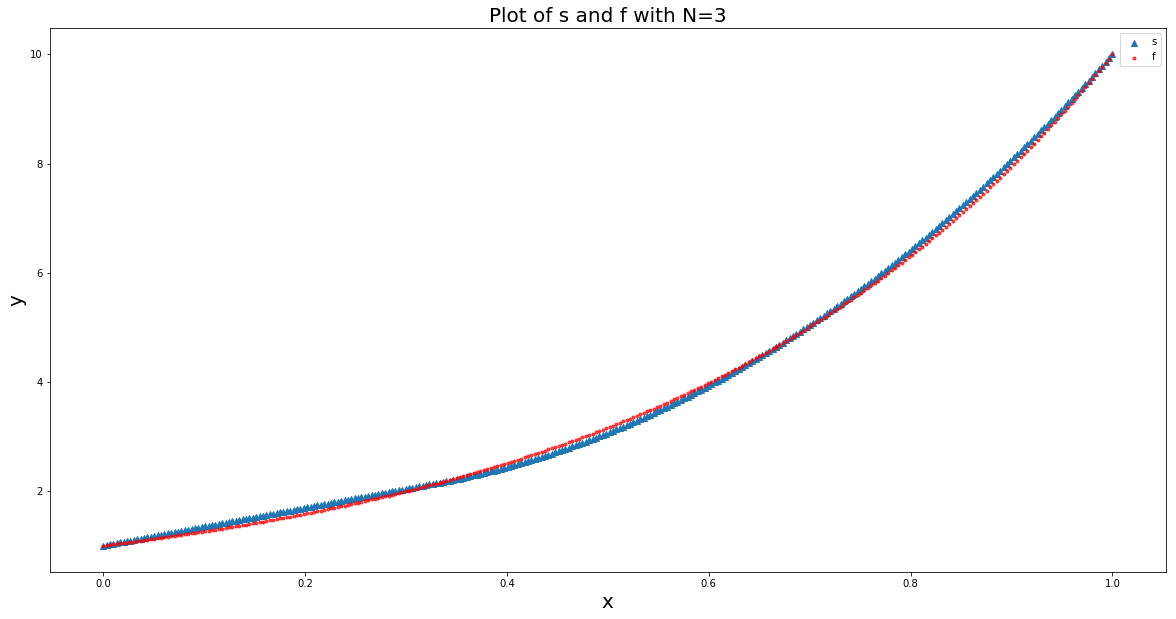

In [163]:
N = 3
splines = get_spline_coeff(N)

plt.figure(figsize=(20,10))
domain_plot_s = np.zeros(100*N)
sks = np.zeros(100*N)
fs = np.zeros(100*N)
for k in range(N):
    xs = np.linspace(k/N, (k+1)/N, 100)
    ak, bk, ck = splines[k*3:(k+1)*3]

    domain_plot_s[100*k:100*(k+1)] = xs
    sks[100*k:100*(k+1)] = [ak*x**2 + bk*x + ck for x in xs]
    fs[100*k:100*(k+1)] = [10**x for x in xs]
    
plt.scatter(domain_plot_s, sks, marker='^', label="s")
plt.scatter(domain_plot_s, fs, marker='.', color='r', alpha=0.7, label="f")
plt.title("Plot of s and f with N={}".format(N), fontsize=20)
plt.xlabel("x", fontsize=20)
plt.ylabel("y", fontsize=20)
_ = plt.legend()

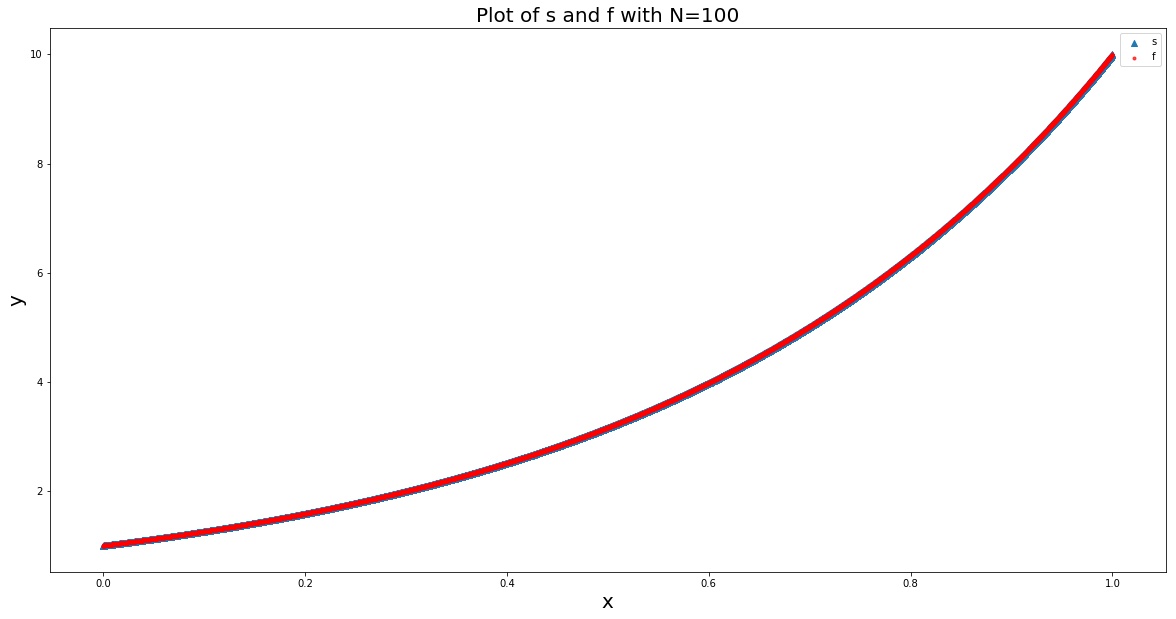

In [165]:
N = 100
splines = get_spline_coeff(N, v=False)

plt.figure(figsize=(20,10))
domain_plot_s = np.zeros(100*N)
sks = np.zeros(100*N)
fs = np.zeros(100*N)
for k in range(N):
    xs = np.linspace(k/N, (k+1)/N, 100)
    ak, bk, ck = splines[k*3:(k+1)*3]

    domain_plot_s[100*k:100*(k+1)] = xs
    sks[100*k:100*(k+1)] = [ak*x**2 + bk*x + ck for x in xs]
    fs[100*k:100*(k+1)] = [10**x for x in xs]
    
plt.scatter(domain_plot_s, sks, marker='^', label="s")
plt.scatter(domain_plot_s, fs, marker='.', color='r', alpha=0.7, label="f")
plt.title("Plot of s and f with N={}".format(N), fontsize=20)
plt.xlabel("x", fontsize=20)
plt.ylabel("y", fontsize=20)
_ = plt.legend()

#### c) Calculate the integral $I[f] = \int_0^1 f(x)dx$.

$$I[f] = \int_0^1 10^x dx = \frac{9}{\ln(10)}$$

$$I[s] = \int_0^1 s(x)dx = \sum_{k=0}^{N-1} \left[ \int_{\frac{k}{N}}^{\frac{k+1}{N}} s_k(x)dx\right]$$

$$ I[s] = \sum_{k=0}^{N-1} \left[ \frac{a_kx^3}{3} + \frac{b_kx^2}{2} + c_kx \right]_{\frac{k}{N}}^{\frac{k+1}{N}}$$

$$ I[s] = \sum_{k=0}^{N-1} \left[ \frac{a_k}{3N^3} (3k^2 +3k+1) + \frac{b_k}{2N^2} (2k+1) + \frac{c_k}{N} \right] $$

In [178]:
def get_area_s(splines):
    N = round(len(splines)/3)
    area = 0
    
    for k in range(N):
        ak, bk, ck = splines[k*3:(k+1)*3]
        
        area += (ak / (3*N**3) * (3*k**2+3*k+1)) + (bk / (2*N**2) * (2*k + 1)) + (ck / N)
        
    return area

In [218]:
Eh_domain = [1/N for N in range(5, 61, 5)]
Ehs = [abs(9/np.log(10) - get_area_s(get_spline_coeff(N, v=False))) for N in range(5, 61, 5)]

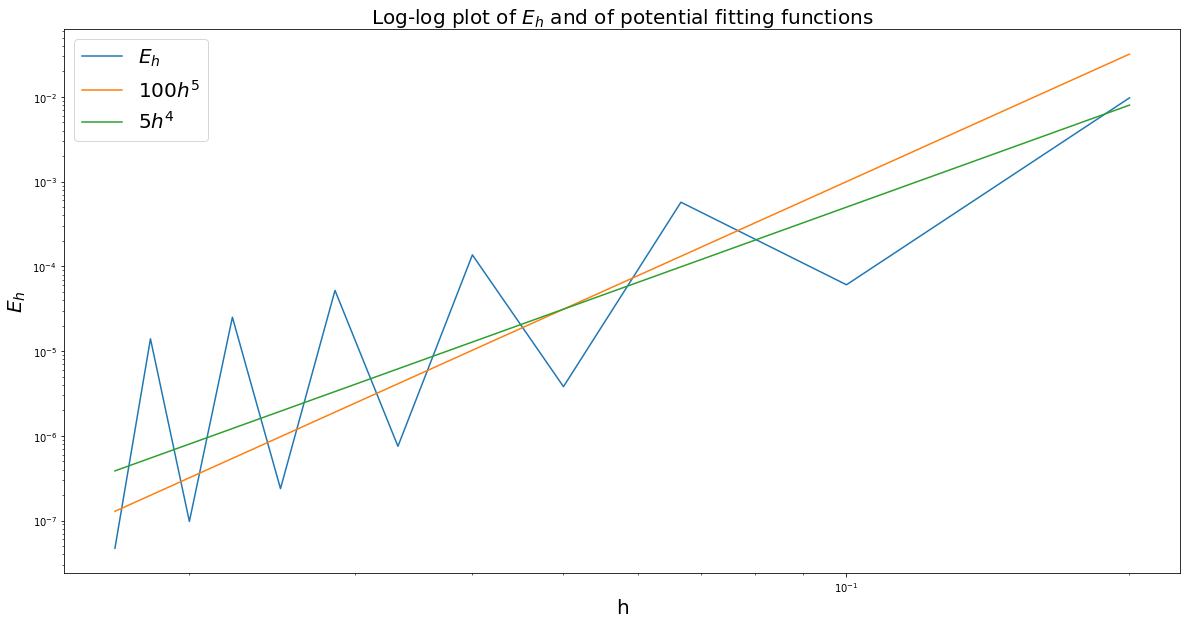

In [225]:
plt.figure(figsize=(20,10))
plt.loglog(Eh_domain, Ehs, label=r"$E_h$")
plt.loglog(Eh_domain, [100 * h**5 for h in Eh_domain], label=r"$100h^5$")
plt.loglog(Eh_domain, [5 * h**4 for h in Eh_domain], label=r"$5h^4$")
plt.title(r"Log-log plot of $E_h$ and of potential fitting functions", fontsize=20)
plt.xlabel("h", fontsize=20)
plt.ylabel(r"$E_h$", fontsize=20)
_ = plt.legend(fontsize=20)

From looking at the graph, the rate of convergence of $E_h$ seems to be between $O(h^4)$ and $O(h^5)$.

### Question 3: Stability of a numerical scheme for advection.

#### a) By substituting in the ansatz $U_j^n = \lambda(k)^n e^{ijk\Delta x}$, calculate an expression for the amplification factor $\lambda(k)$

$$ U_j^{n+1} = U_j^n - \frac{v}{2} \left( 3U_j^n - 4U_{j-1}^n + U_{j-2}^n\right)$$

$$ \lambda(k)^{n+1} e^{ijk\Delta x} = \lambda(k)^n e^{ijk\Delta x} - \frac{v}{2} \left( 3\lambda(k)^n e^{ijk\Delta x} - 4\lambda(k)^n e^{i(j-1)k\Delta x} + \lambda(k)^n e^{i(j-2)k\Delta x}\right)$$

If we divide by $\lambda(k)^n e^{ijk\Delta x}$

$$ \lambda(k) = 1 - \frac{v}{2} \left( 3 - 4e^{-ik\Delta x} + e^{-2ik\Delta x} \right)$$

$$ \lambda(k) = 1 - \frac{v}{2} \left[3 - 4\cos(k\Delta x) + \cos(2k\Delta x) + (4\sin(k\Delta x) - sin(2k\Delta x))i \right] $$

Finally, let's separate the real and the imaginary parts.

$$ \lambda(k) = \left[1 - \frac{v}{2} (3 - 4\cos(k\Delta x) + \cos(2k\Delta x)) \right] + \left[ -\frac{v}{2} (4\sin(k\Delta x) - sin(2k\Delta x))i \right] $$


#### b) Define $A(k) = |\lambda(k)|^2$. Calculate a Taylor series for *A* at $k = 0$ to second order. Explain why we consider the numerical scheme to be unstable regardless of the choice of timestep.

$$ A(k) = |\lambda(k)|^2 = \left[1 - \frac{v}{2} (3 - 4\cos(k\Delta x) + \cos(2k\Delta x)) \right]^2 + \left[ -\frac{v}{2} (4\sin(k\Delta x) - sin(2k\Delta x)) \right]^2 $$

$$ A(0) = 1 $$

If we Taylor expand $A(k)$

$$ A(k) = A(0) + A'(0)k + \frac{A''(0)k^2}{2} + O(k^3) $$

To be stable, $|\lambda(k)|^2 = A(k) \leq 1$

$$A(0) + A'(0)k + \frac{A''(0)k^2}{2} + O(k^3) \leq 1 $$

Knowing that $A(0) = 1$, and that the first and second derivatives at $k=0$ are also $0$.

$$ 1 + 0k + \frac{0k^2}{2} + O(k^3) \leq 1 $$

$$ O(k^3) \leq 0$$

The stability of this numerical scheme does not depend in any way on the choice of timestep, it only depends on the truncation error of the Taylor series. We can't guarantee that $O(k^3)$ will be $0$ for any $k$, and so the stability condition cannot be enforced: hence, the scheme is unstable. In fact, in the plot in *c)*, we see that $A(k) > 1$ for some $k$s.

#### c) Make two plots of $A(k)$ for $v=\frac{1}{100}$ using two different axis ranges.

In [8]:
def A(k_deltax):
    v = 1/100
    
    firstTerm = (1- v/2 * (3 - 4*np.cos(k_deltax) + np.cos(2*k_deltax)))**2
    secondTerm = (-v/2 * (4*np.sin(k_deltax) - np.sin(2*k_deltax)))**2
    
    return firstTerm + secondTerm

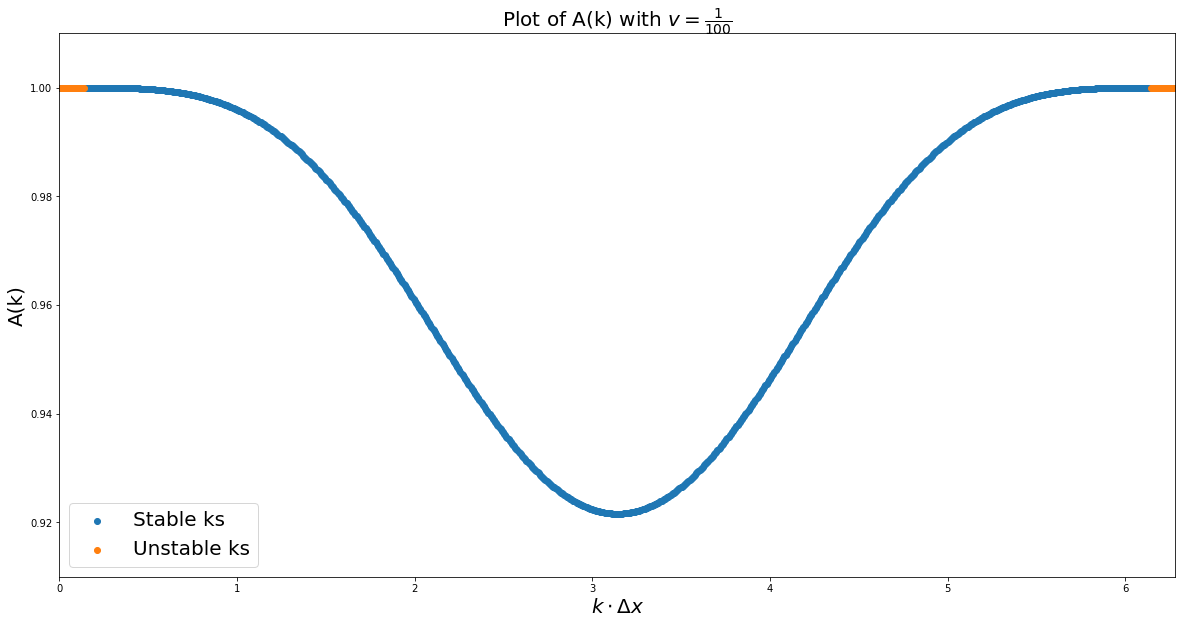

In [22]:
domain_A_plot = np.linspace(0, 2*np.pi, 1000)
stable_A_domain = []
stable_A_values = []
unstable_A_domain = []
unstable_A_values = []

for kx in domain_A_plot:
    value = A(kx)
    if value <= 1:
        stable_A_domain.append(kx)
        stable_A_values.append(value)
    else:
        unstable_A_domain.append(kx)
        unstable_A_values.append(value)
        
plt.figure(figsize=(20,10))
axes = plt.gca()
axes.set_xlim([0,2*np.pi])
axes.set_ylim([0.91, 1.01])
plt.scatter(stable_A_domain, stable_A_values, label="Stable ks")
plt.scatter(unstable_A_domain, unstable_A_values, label="Unstable ks")
plt.title(r"Plot of A(k) with $v=\frac{1}{100}$", fontsize=20)
plt.xlabel(r"$k \cdot \Delta x$", fontsize=20)
plt.ylabel("A(k)", fontsize=20)
_ = plt.legend(fontsize=20)

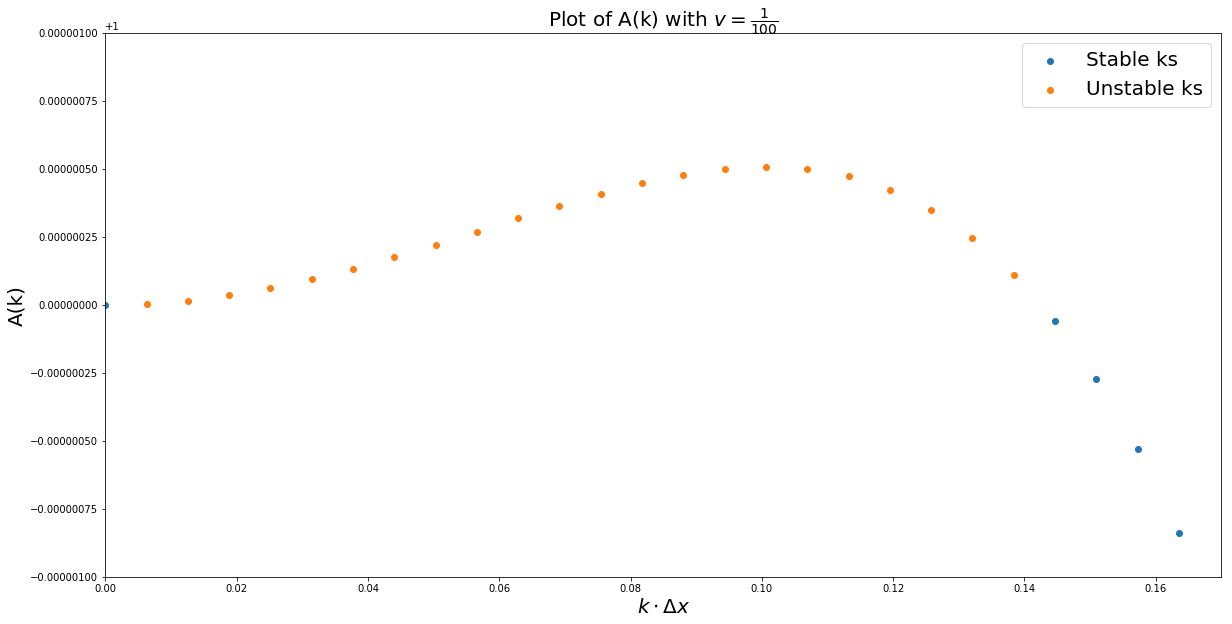

In [20]:
plt.figure(figsize=(20,10))
axes = plt.gca()
axes.set_xlim([0, 0.17])
axes.set_ylim([1 - 1e-6, 1 + 1e-6])
plt.scatter(stable_A_domain, stable_A_values, label="Stable ks")
plt.scatter(unstable_A_domain, unstable_A_values, label="Unstable ks")
plt.title(r"Plot of A(k) with $v=\frac{1}{100}$", fontsize=20)
plt.xlabel(r"$k \cdot \Delta x$", fontsize=20)
plt.ylabel("A(k)", fontsize=20)
_ = plt.legend(fontsize=20)

#### d) Write a program to simulate Eq. 5 on a periodic interval $[0, 2\pi)$ using $N = 40$ gridpoints, and a grid spacing of $\Delta x = \frac{2\pi}{N}$.

Recall that Eq.5 can be rewritten as $$ U_j^{n+1} = U_j^n - \frac{v}{2} \left( 3U_j^n - 4U_{j-1}^n + U_{j-2}^n\right)$$

Also, $v=\frac{1}{100}$, and the initial condition is $U_j^0 = e^{2\sin(j \cdot \Delta x)}$.

In [44]:
get_N = lambda: 40
get_deltax = lambda: 2*np.pi/get_N()

def plot_eq5(grid, n):
    deltax = get_deltax()
    
    plt.figure(figsize=(20,10))
    plt.plot([j*deltax for j in range(get_N())], grid)
    plt.title("Equation 5 at n={}".format(n), fontsize=20)
    plt.xlabel("x", fontsize=20)
    plt.ylabel("U", fontsize=20)
    
def compute_M(grid):
    M = 0
    for value in grid:
        M += value**2
    
    return np.sqrt(M/get_N())

def simulate_eq5(steps=100000):
    N = get_N()
    deltax = get_deltax()
    v = 1/100
    ns_of_interest = {1000, 2000, 4000, 50000, steps-1}
    M = np.zeros(steps)
    
    # populate memoized values for U^0
    prevU = [np.e**(2*np.sin(j*deltax)) for j in range(N)]
    currU = np.zeros(N)
    M[0] = compute_M(prevU)
    
    # plot n=0
    plot_eq5(prevU, 0)

    for np1 in range(1, steps):
        for j in range(N):
            currU[j] = prevU[j] - v/2 * (3*prevU[j] - 4*prevU[j-1] + prevU[j-2])
            
        prevU = currU
        M[np1] = compute_M(prevU)
            
        if np1 in ns_of_interest:
            plot_eq5(currU, np1)
            
    return M

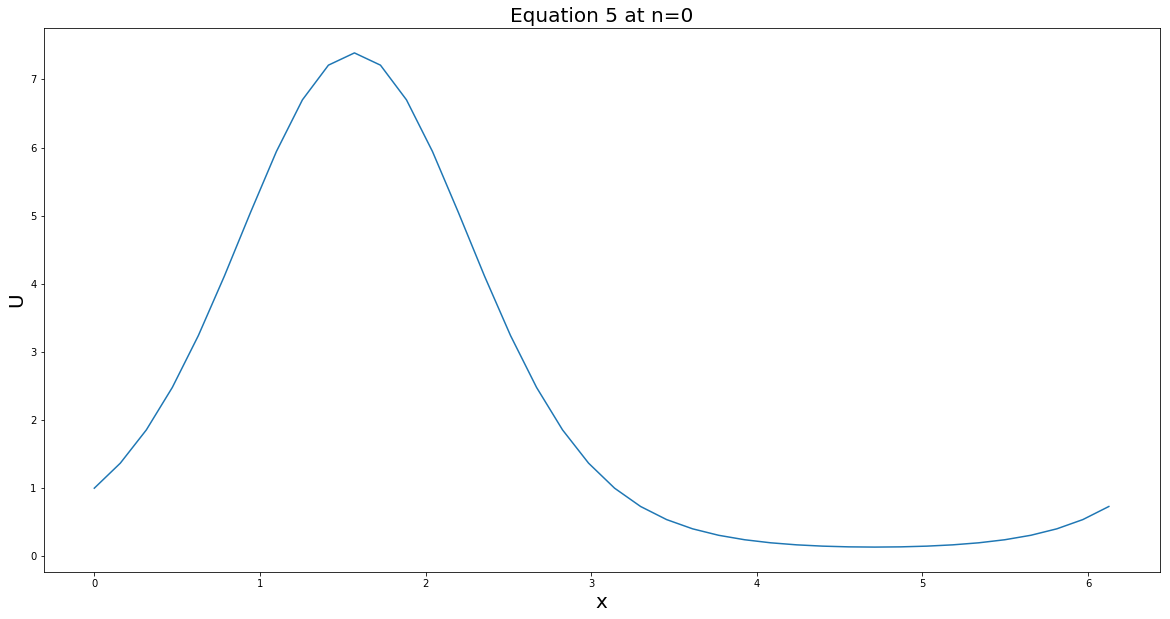

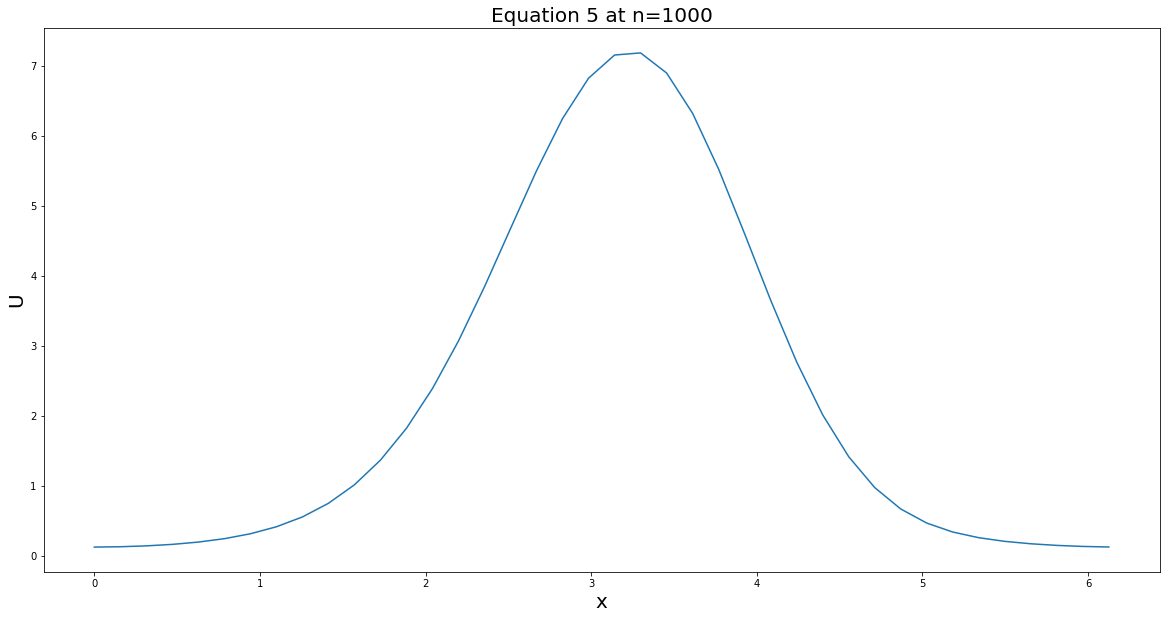

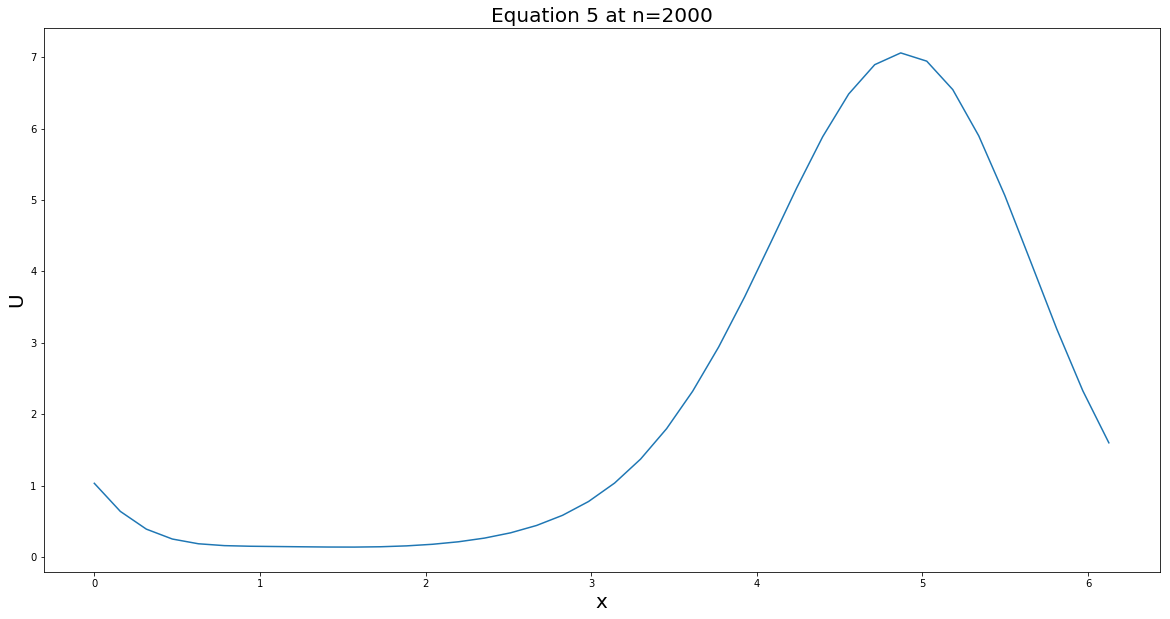

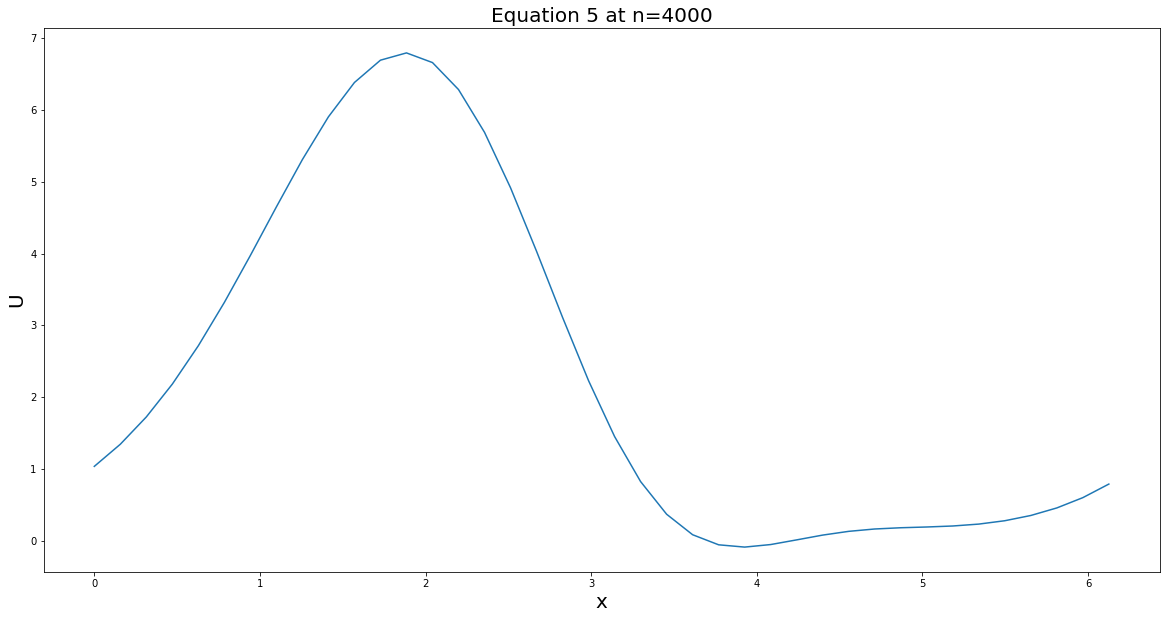

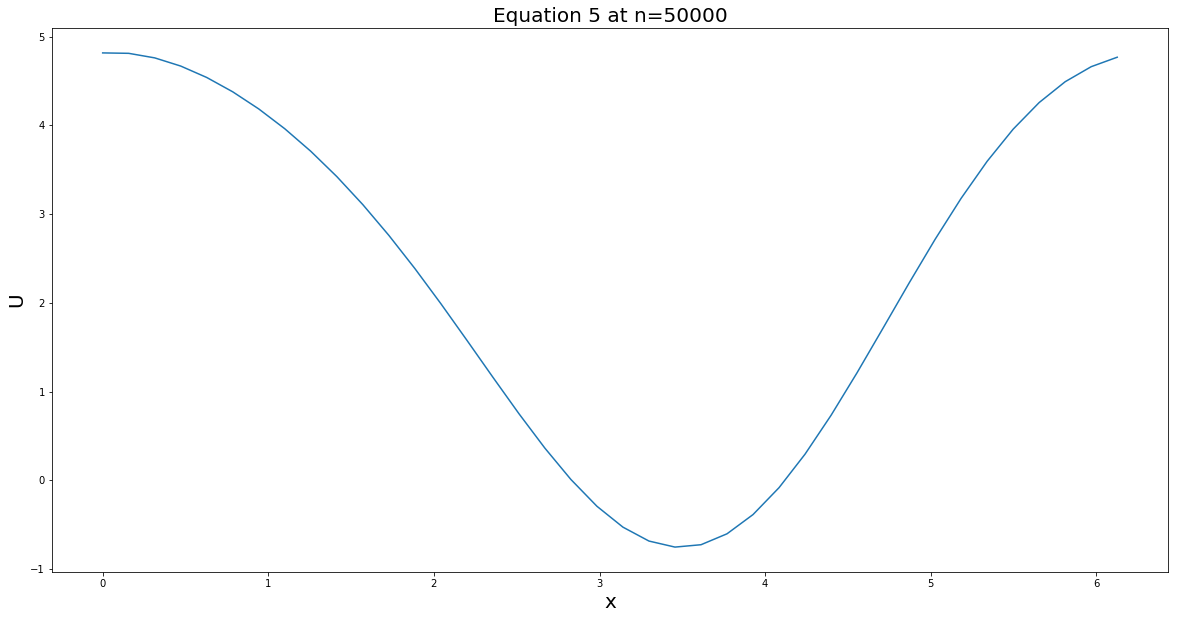

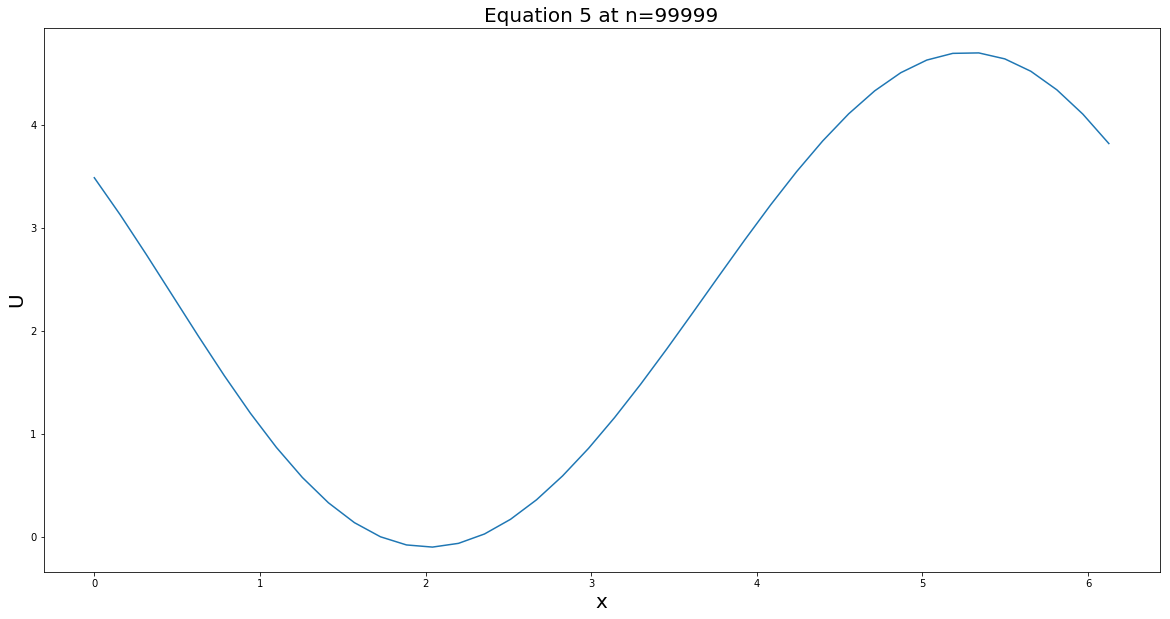

In [45]:
M = simulate_eq5()

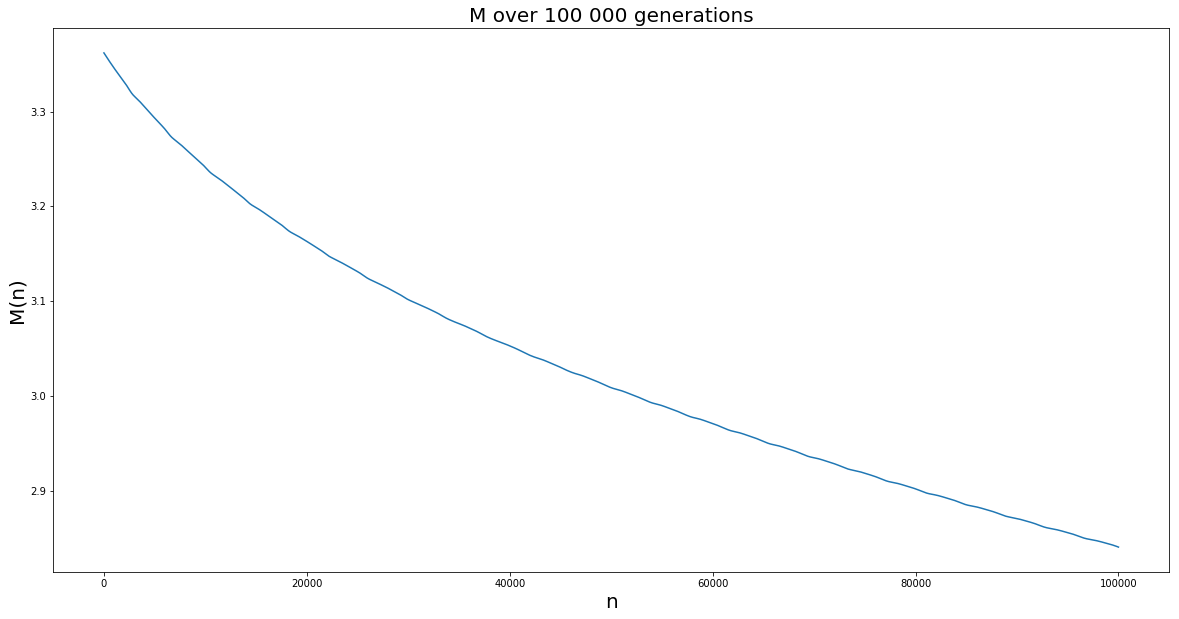

In [48]:
plt.figure(figsize=(20,10))
plt.plot(M)
plt.title("M over 100 000 generations", fontsize=20)
plt.xlabel("n", fontsize=20)
_ = plt.ylabel("M(n)", fontsize=20)

Indeed, $M$ does not increase over time, so the method is stable.